## DC Catlab stratification example
Use a more programmatic approach for stratification

In [1]:
# Imports
using AlgebraicPetri
using AlgebraicPetri.ModelComparison
using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Programs
using Catlab.WiringDiagrams
using Catlab.Graphics.Graphviz
using Catlab.Graphics.Graphviz: Html
using Plots
using JSON
using LabelledArrays
using PrettyTables

using GraphViz

In [2]:
# Functions for graphing typed Petri nets
colors = ["#a08eae","#ffeec6", "#a8dcd9", "#ffeec6", "#a8dcd9"]

function def_trans(typed_petri::ACSetTransformation, colors; labels = true)
  (p, t; pos = "") -> ("t$t", Attributes(
             :label => labels ? Html(flatten(tname(p,t))) : "" ,
             :shape=>"square",
             :color=>colors[typed_petri[:T](t)],
             :pos=>pos))
end

function def_trans(colors = colors; labels = true)
  (p, t; pos = "") -> ("t$t", Attributes(
             :label => labels ? "$(tname(p, t))" : "" ,
             :shape=>"square",
             :color=>colors[t],
             :pos=>pos))
end

flatten(tname::Symbol) = "$tname"

function flatten(tname::Tuple)
    names = split(replace(string(tname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_states(p, s; pos="") = ("s$s", Attributes(
        :label => sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
        :shape=>"circle",
        :color=>"#6C9AC3",
        :pos=>pos
))

Graph_typed(typed_petri::ACSetTransformation, colors = colors; labels = true) = Graph(dom(typed_petri),
    make_trans = def_trans(typed_petri, colors; labels = labels),
    make_states = def_states
)

Graph_typed (generic function with 2 methods)

In [78]:
# Define types
infection_type = LabelledPetriNet([:Pop],
  :t_interact=>((:Pop, :Pop)=>(:Pop, :Pop)), 
  :t_strata=>(:Pop=>:Pop)
)
""

""

In [79]:
t = parts(infection_type, :T)

1:2

In [80]:
map(x -> x, t)

2-element Vector{Int64}:
 1
 2

In [81]:
map(x -> infection_type.subparts.tname[x], t)

2-element Vector{Symbol}:
 :t_interact
 :t_strata

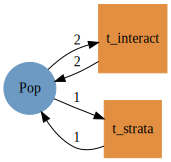

In [82]:
Graph(infection_type)

In [83]:
SIR = LabelledPetriNet([:S, :I],
  :inf => ((:S, :I)=>(:I, :I)),
  :id => (:S => :S),
  :id => (:I => :I)
)

quarantine = LabelledPetriNet([:Q, :NotQ],
    :id => (:Q => :Q),
    :id => (:NotQ => :NotQ),
    :enter_q => (:NotQ => :Q),
    :exit_q => (:Q => :NotQ),
    :t_interact => ((:NotQ, :NotQ) => (:NotQ, :NotQ))
)
""

""

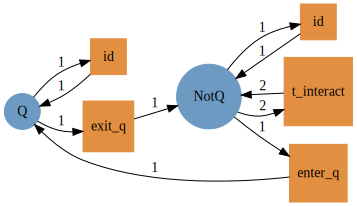

In [54]:
Graph(quarantine)

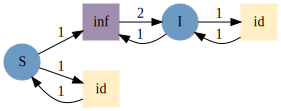

In [84]:
s, = parts(infection_type, :S)
t_interact, t_strata = parts(infection_type, :T)
i_interact1, i_interact2, i_strata = parts(infection_type, :I)
o_interact1, o_interact2, o_strata = parts(infection_type, :O);

typed_SIR = ACSetTransformation(SIR, infection_type,
  S = [s, s],
  T = [t_interact, t_strata, t_strata],
  I = [i_interact1, i_interact2, i_strata, i_strata],
  O = [o_interact1, o_interact2, o_strata, o_strata],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
)
Graph_typed(typed_SIR)

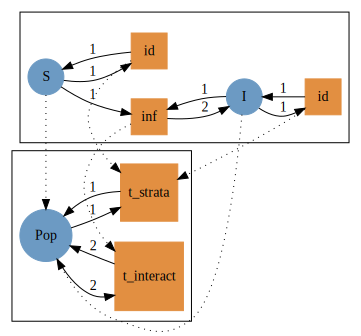

In [85]:
Graph(typed_SIR)

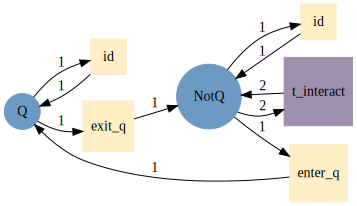

In [86]:
typed_quarantine = ACSetTransformation(quarantine, infection_type,
    S = [s, s],
    T = [t_disease, t_disease, t_strata, t_strata, t_interact],
    I = [i_disease, i_disease, i_strata, i_strata, i_interact1, i_interact2],
    O = [o_disease, o_disease, o_strata, o_strata, o_interact1, o_interact2],
    Name = name -> nothing
)
Graph_typed(typed_quarantine)

In [62]:
# Stratify the models together
stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2))

typed_stratify(typed_model1, typed_model2) =
  compose(proj1(pullback(typed_model1, typed_model2)), typed_model1);

In [87]:
SIR_quarantine_typed = typed_stratify(typed_SIR, typed_quarantine)

LoadError: Pullbacks of TypeSets that are not products are not supported